<a href="https://colab.research.google.com/github/fbelinchon/ml/blob/master/Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicialización

In [ ]:
!pip install -Uqq fastai dtreeviz

Enlazamos Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import de librerias necesaria

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG,display
from pathlib import *
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn import metrics
import matplotlib.pylab as plt
#%matplotlib inline 
from matplotlib.pylab import rcParams 

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
rcParams['figure.figsize'] = 12, 4 

In [ ]:
path= PosixPath('/content/drive/MyDrive/data/bigmartsales')

In [ ]:
df=pd.read_csv(path/'train.csv',delimiter=',')
df_test=pd.read_csv(path/'test.csv',delimiter=',')

# Modelo Base

## Leemos los datos desde fichero csv y lo cargamos en forma DataFrame.

In [ ]:
pd.options.display.max_columns = 40
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Tratamiento básico para poder generar un modelo base sencillo

Tratamiento básico. La idea es generar un modelo de partida lo más rápido posible.
1. Si tenemos campos de tipo fecha les aplicamos el tratamiento de fechas por defecto.
2. Tratamos los campos NULOS y separamos los campos continuos de los campos tipos variables.

Para simplificar este prtoceso utilizamos TabularPandas de FASTAI

In [ ]:
#df['DOB']=df['DOB'].astype('datetime64','%d-%mon-%yy')
#df['Lead_Creation_Date']=df['Lead_Creation_Date'].astype('datetime64','%d-%mon-%yy')

In [ ]:
#df = add_datepart(df, 'DOB')
#df = add_datepart(df, 'Lead_Creation_Date')

Los pasos son:
1. Primero indicamos cual es la variable dependiente
2. Mirtamos que campos son variables continuas y cuales de categoría.
2. Creamos la función para separar los datos de entrenamiento y los datos de validación
3. Indicamos las transformaciones básicas (Categorify y FillNullify)

In [ ]:
dep_var='Item_Outlet_Sales'

In [ ]:
cont,cat = cont_cat_split(df,max_card=200,dep_var=dep_var)

In [ ]:
splits = RandomSplitter(seed=48)(range_of(df))

In [ ]:
procs=[Categorify,FillMissing]
to=TabularPandas(df,procs=procs,cat_names=cat,cont_names=cont,y_names=dep_var,splits=splits)

Guardamos el objeto TabularPandas como base.

In [ ]:
save_pickle(path/'to_base.pkl',to)

## Creamos un modelo Ramdom Forest sencillo para tener un modelo base de inicio sobre el que mejorar.

In [ ]:
to=load_pickle(path/'to_base.pkl')

In [ ]:
def modelfit(alg, X,y,printFeatureImportance=True): 
    #Fit the algorithm on the data 
    alg.fit(X, y) 
    
    #Predict training set:
    dtrain_predictions = alg.predict(X) 
        
    #Print model report:
    print("/nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, dtrain_predictions)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,list(X.columns)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
def result_reg(m,X,y):
    predictions = m.predict(X)
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, predictions)))
 
    

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
train_x.shape,valid_x.shape

((6819, 12), (1704, 12))

In [ ]:
def rf(xs, y, n_estimators=100, max_samples=200,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m_rf = rf(train_x, train_y);

/nModel Report
RMSE : 1082


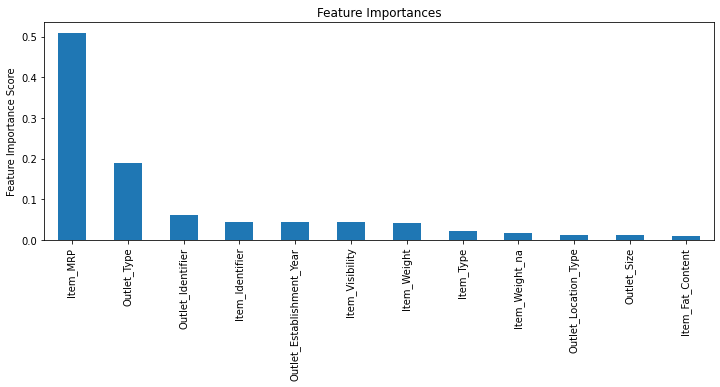

In [ ]:
modelfit(m_rf, train_x,train_y)

In [ ]:
result_reg(m_rf,valid_x,valid_y)

RMSE : 1133


Con un modelo sencillo hemos obtenido un error de partida de:
 - RMSE_train: 1100
 - RMSE_valid=:1094

Nos informa también de la importancia de las variable. De esta forma nos podemos centrar en las que tienen más impacto.

Grabamos este modelo

In [ ]:
save_pickle(path/'model_rf_base.pkl',m_rf)

# Features engineering

## Primero analizamos si existen muchos nulos en algún campo en concreto.


Vemos que hay dos campos con muchos nulos (ItemWeight y Outlet_Size)

In [ ]:
to = load_pickle(path/'to_base.pkl')

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
def null_values(df):
    frame = { 'null_values': (df.isnull().sum()), '%': ((df.isnull().sum())/len(df))*100 }
    return pd.DataFrame(frame)

In [ ]:
null_values(df)

,null_values,%
Item_Identifier,0,0.000000
Item_Weight,1463,17.165317
Item_Fat_Content,0,0.000000
Item_Visibility,0,0.000000
Item_Type,0,0.000000
Item_MRP,0,0.000000
Outlet_Identifier,0,0.000000
Outlet_Establishment_Year,0,0.000000
Outlet_Size,2410,28.276428
Outlet_Location_Type,0,0.000000


Tenemos que analizar los Nullos de los campos 'Item_Weight' y 'Outlet_Size'.

Comprobamos si podemos adivinar los valores mejor que simplemente utilizando la media.

### Vamos a revisar Outlet_Size

In [ ]:
df.loc[df['Outlet_Size'].isnull(),['Outlet_Identifier','Outlet_Size','Outlet_Type']]

,Outlet_Identifier,Outlet_Size,Outlet_Type
3,OUT010,NaN,Grocery Store
8,OUT045,NaN,Supermarket Type1
9,OUT017,NaN,Supermarket Type1
25,OUT017,NaN,Supermarket Type1
28,OUT010,NaN,Grocery Store
...,...,...,...
8502,OUT045,NaN,Supermarket Type1
8508,OUT045,NaN,Supermarket Type1
8509,OUT010,NaN,Grocery Store
8514,OUT045,NaN,Supermarket Type1


In [ ]:
df.loc[df['Outlet_Size'].isnull(),['Outlet_Identifier']].value_counts()

Outlet_Identifier
OUT045               929
OUT017               926
OUT010               555
dtype: int64

Tenemos 3 Outlet con errores en el tamaño.
- OUT045: Type 1
- OUT017: Type 1
- OUT010: Grocery Store

In [ ]:
df.loc[df['Outlet_Type'] =='Grocery Store','Outlet_Size'].value_counts() # Todas Grocery son SMALL

Small    528
Name: Outlet_Size, dtype: int64

Grocery Store cambiamos Outlet_Size por SMALL

In [ ]:
df.loc[df['Outlet_Type'] =='Supermarket Type1',['Outlet_Size']].value_counts() # Todas Grocery son SMALL

Outlet_Size
Small          1860
High            932
Medium          930
dtype: int64

Está igualado. Vamos a ver si podemos mejorar la estimación

In [ ]:
df.loc[(df['Outlet_Type'] =='Supermarket Type1') & (df['Outlet_Location_Type'] =='Tier 1'),'Outlet_Size'].value_counts()

Small     930
Medium    930
Name: Outlet_Size, dtype: int64

In [ ]:
df.loc[(df['Outlet_Type'] =='Supermarket Type1') & (df['Outlet_Location_Type'] =='Tier 2'),'Outlet_Size'].value_counts()

Small    930
Name: Outlet_Size, dtype: int64

In [ ]:
df.loc[(df['Outlet_Type'] =='Supermarket Type1') & (df['Outlet_Location_Type'] =='Tier 3'),'Outlet_Size'].value_counts()

High    932
Name: Outlet_Size, dtype: int64

Tiar 3 siempre HIGHT, Tier 2 siempre 'SMALL', Tier 1 a la mitad. Podemos añadir uno nuevo 'MED' 

In [ ]:
df_copy=df.copy()

In [ ]:
df_copy.fillna(value={'Outlet_Size':'Small'},inplace=True)

In [ ]:
df_copy.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
dep_var='Item_Outlet_Sales'

In [ ]:
cont,cat = cont_cat_split(df_copy,max_card=200,dep_var=dep_var)

In [ ]:
splits = RandomSplitter(seed=48)(range_of(df_copy))

In [ ]:
procs=[Categorify,FillMissing]
to=TabularPandas(df_copy,procs=procs,cat_names=cat,cont_names=cont,y_names=dep_var,splits=splits)

In [ ]:
to.classes

{'Item_Fat_Content': ['#na#', 'LF', 'Low Fat', 'Regular', 'low fat', 'reg'],
 'Item_Identifier': ['#na#', 'DRA12', 'DRA24', 'DRA59', 'DRB01', 'DRB13', 'DRB24', 'DRB25', 'DRB48', 'DRC01', 'DRC12', 'DRC13', 'DRC24', 'DRC25', 'DRC27', 'DRC36', 'DRC49', 'DRD01', 'DRD12', 'DRD13', 'DRD15', 'DRD24', 'DRD25', 'DRD27', 'DRD37', 'DRD49', 'DRD60', 'DRE01', 'DRE03', 'DRE12', 'DRE13', 'DRE15', 'DRE25', 'DRE27', 'DRE37', 'DRE48', 'DRE49', 'DRE60', 'DRF01', 'DRF03', 'DRF13', 'DRF15', 'DRF23', 'DRF25', 'DRF27', 'DRF36', 'DRF37', 'DRF48', 'DRF49', 'DRF51', 'DRF60', 'DRG01', 'DRG03', 'DRG11', 'DRG13', 'DRG15', 'DRG23', 'DRG25', 'DRG27', 'DRG36', 'DRG37', 'DRG39', 'DRG48', 'DRG49', 'DRG51', 'DRH01', 'DRH03', 'DRH11', 'DRH13', 'DRH15', 'DRH23', 'DRH25', 'DRH36', 'DRH37', 'DRH39', 'DRH49', 'DRH51', 'DRH59', 'DRI01', 'DRI03', 'DRI11', 'DRI13', 'DRI23', 'DRI25', 'DRI37', 'DRI39', 'DRI47', 'DRI49', 'DRI51', 'DRI59', 'DRJ01', 'DRJ11', 'DRJ13', 'DRJ23', 'DRJ24', 'DRJ25', 'DRJ35', 'DRJ37', 'DRJ39', 'DRJ47', 'DR

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
m_rf = rf(train_x, train_y);

/nModel Report
RMSE : 1079


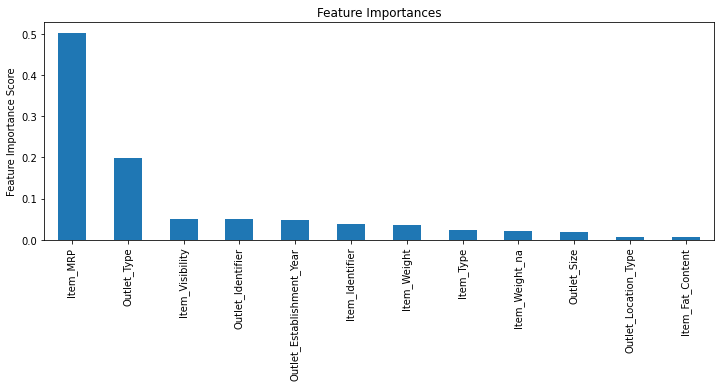

In [ ]:
modelfit(m_rf, train_x,train_y)

In [ ]:
result_reg(m_rf,valid_x,valid_y)

RMSE : 1129


Se produce una mejora 
- RMSE_train=1089
- RSME_valid=1137

### Vamos a revisar Item Weight

In [ ]:
df.loc[:,['Item_Identifier','Item_Weight','Item_MRP','Item_Type']]

,Item_Identifier,Item_Weight,Item_MRP,Item_Type
0,FDA15,9.300,249.8092,Dairy
1,DRC01,5.920,48.2692,Soft Drinks
2,FDN15,17.500,141.6180,Meat
3,FDX07,19.200,182.0950,Fruits and Vegetables
4,NCD19,8.930,53.8614,Household
...,...,...,...,...
8518,FDF22,6.865,214.5218,Snack Foods
8519,FDS36,8.380,108.1570,Baking Goods
8520,NCJ29,10.600,85.1224,Health and Hygiene
8521,FDN46,7.210,103.1332,Snack Foods


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05bd8a3f90>,
      dtype=object)

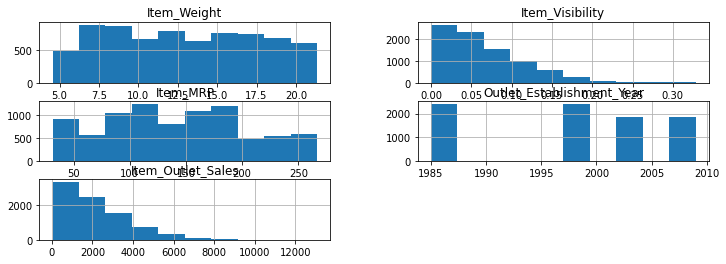

In [ ]:
df.hist()

## Vamos a comprobar las clases Categorical

No hay mucha mejora. Vamos a eliminar el campo

In [ ]:
to.classes

{'Item_Fat_Content': ['#na#', 'LF', 'Low Fat', 'Regular', 'low fat', 'reg'],
 'Item_Identifier': ['#na#', 'DRA12', 'DRA24', 'DRA59', 'DRB01', 'DRB13', 'DRB24', 'DRB25', 'DRB48', 'DRC01', 'DRC12', 'DRC13', 'DRC24', 'DRC25', 'DRC27', 'DRC36', 'DRC49', 'DRD01', 'DRD12', 'DRD13', 'DRD15', 'DRD24', 'DRD25', 'DRD27', 'DRD37', 'DRD49', 'DRD60', 'DRE01', 'DRE03', 'DRE12', 'DRE13', 'DRE15', 'DRE25', 'DRE27', 'DRE37', 'DRE48', 'DRE49', 'DRE60', 'DRF01', 'DRF03', 'DRF13', 'DRF15', 'DRF23', 'DRF25', 'DRF27', 'DRF36', 'DRF37', 'DRF48', 'DRF49', 'DRF51', 'DRF60', 'DRG01', 'DRG03', 'DRG11', 'DRG13', 'DRG15', 'DRG23', 'DRG25', 'DRG27', 'DRG36', 'DRG37', 'DRG39', 'DRG48', 'DRG49', 'DRG51', 'DRH01', 'DRH03', 'DRH11', 'DRH13', 'DRH15', 'DRH23', 'DRH25', 'DRH36', 'DRH37', 'DRH39', 'DRH49', 'DRH51', 'DRH59', 'DRI01', 'DRI03', 'DRI11', 'DRI13', 'DRI23', 'DRI25', 'DRI37', 'DRI39', 'DRI47', 'DRI49', 'DRI51', 'DRI59', 'DRJ01', 'DRJ11', 'DRJ13', 'DRJ23', 'DRJ24', 'DRJ25', 'DRJ35', 'DRJ37', 'DRJ39', 'DRJ47', 'DR

EL campo Item_Fat_Content tiene valores repetidos. 
- LF , Low Fat y low fat se convierten en LOW FAT
- Regular y reg en REGULAR

In [ ]:
df_copy['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
df_copy['Item_Fat_Content']=df_copy['Item_Fat_Content'].map(lambda x : 'LOW FAT' if x in ['Low Fat','LF','low fat'] else 'REG')

In [ ]:
df_copy.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,...,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,LOW FAT,0.016047,...,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,REG,0.019278,...,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,LOW FAT,0.016760,...,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,REG,0.000000,...,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,LOW FAT,0.000000,...,High,Tier 3,Supermarket Type1,994.7052


Vamos a ver Item_Identifier

In [ ]:
df.Item_Identifier.value_counts()

FDG33    10
FDW13    10
FDV60     9
NCF42     9
FDX04     9
         ..
FDC23     1
FDY43     1
FDT35     1
FDE52     1
DRF48     1
Name: Item_Identifier, Length: 1559, dtype: int64

Vamos a probar a eliminarlo

In [ ]:
df_copy.drop('Item_Identifier',axis=1,inplace=True)
df_copy.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,...,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,LOW FAT,0.016047,Dairy,...,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,REG,0.019278,Soft Drinks,...,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,LOW FAT,0.016760,Meat,...,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,REG,0.000000,Fruits and Vegetables,...,Small,Tier 3,Grocery Store,732.3800
4,8.93,LOW FAT,0.000000,Household,...,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
def fastTest(df1):
    dep_var='Item_Outlet_Sales'
    cont,cat = cont_cat_split(df1,max_card=200,dep_var=dep_var)
    splits = RandomSplitter(seed=48)(range_of(df1))

    procs=[Categorify,FillMissing]
    to=TabularPandas(df1,procs=procs,cat_names=cat,cont_names=cont,y_names=dep_var,splits=splits)

    train_x, train_y=to.train.xs,to.train.y
    valid_x,valid_y=to.valid.xs,to.valid.y
    model=rf(train_x, train_y)
    modelfit(rf(train_x, train_y), train_x,train_y)
    print('\n RMSE valid: ') 
    rmse_valid = result_reg(model,valid_x,valid_y)    
    

/nModel Report
RMSE : 1082

 RMSE valid: 
RMSE : 1129


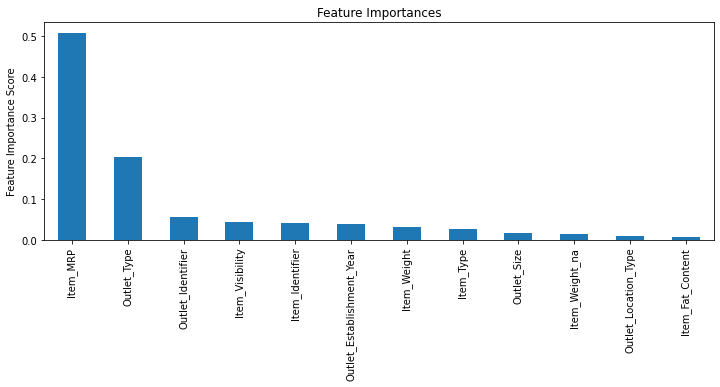

In [ ]:
fastTest(df_copy)

In [ ]:
df_copy['id_new']=df['Item_Identifier'].str[:3]

/nModel Report
RMSE : 1091

 RMSE valid: 
RMSE : 1132


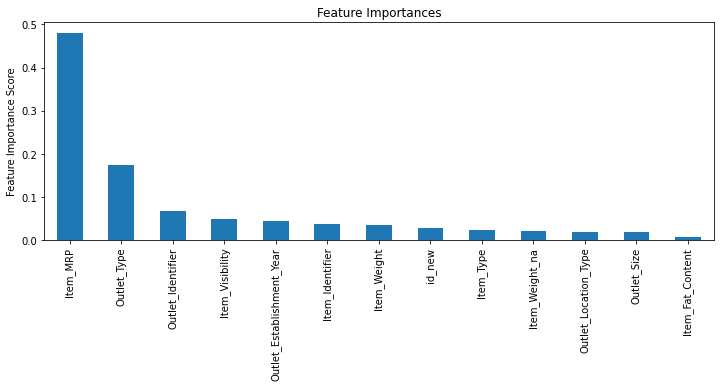

In [ ]:
fastTest(df_copy)

In [ ]:
df_copy2 =df.copy()

In [ ]:
df_copy2['IdItem']=df['Item_Identifier'].str[:3]

In [ ]:
df_copy2['Item_Fat_Content']=df_copy2['Item_Fat_Content'].map(lambda x : 'LOW FAT' if x in ['Low Fat','LF','low fat'] else 'REG')

/nModel Report
RMSE : 1092

 RMSE valid: 
RMSE : 1128


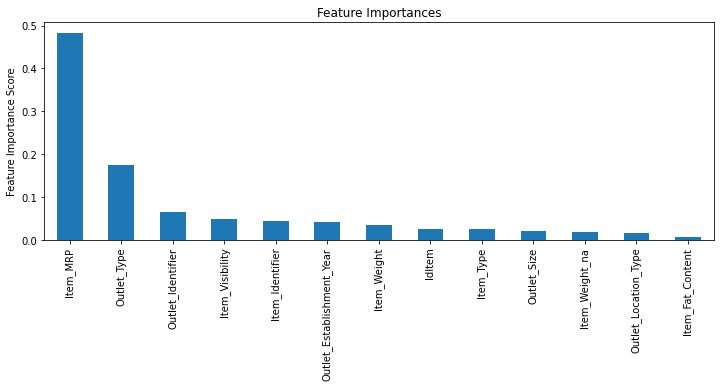

In [ ]:
fastTest(df_copy2)

In [ ]:
save_pickle(path/'to_mod.pkl',to)

# Modelo GBoostModel

In [ ]:
#to = load_pickle(path/'to_full.pkl')
#to = load_pickle(path/'to_opt_nor.pkl')
to = load_pickle(path/'to_mod.pkl')

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor #GBM algorithm 
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn import metrics
#from sklearn.model_selection import cross_validation, metrics #Additional scklearn functions 
from sklearn.model_selection import GridSearchCV #Perforing grid search 
import matplotlib.pylab as plt
#%matplotlib inline 
from matplotlib.pylab import rcParams 

rcParams['figure.figsize'] = 12, 4 


In [ ]:
def modelfit(alg, X,y, performCV=True, printFeatureImportance=True, cv_folds=5): 
    #Fit the algorithm on the data 
    alg.fit(X, y) 
    
    #Predict training set:
    dtrain_predictions = alg.predict(X) 
    #dtrain_predprob = alg.predict_proba(X)[:,1] 
    
    #Perform cross-validation: 
    if performCV:
        cv_score = cross_val_score(alg,X, y, cv=cv_folds, scoring='neg_root_mean_squared_error')
    #Print model report:
    print("/nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, dtrain_predictions)))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)) 
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" %(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))) 
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,list(X.columns)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/nModel Report
RMSE : 1021
CV Score : Mean - -1074.002 | Std - 41.66748 | Min - -1131.118 | Max - -1013.939


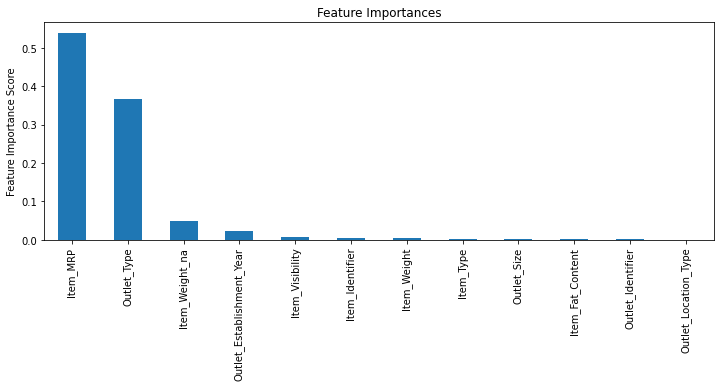

In [ ]:
#Choose all predictors except target & IDcols
#predictors = [x for x in train_x.columns if x not in [IDcol]]
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, train_x,train_y)

In [ ]:
def result(m,X,y,predictors):
    predictions = m.predict(X[predictors])
    predprob = m.predict_proba(X[predictors])[:,1]
    print("Accuracy : %.4g" % metrics.accuracy_score(y, predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, predprob)) 
    metrics.plot_roc_curve(m, X[predictors], y)
    plt.show()

In [ ]:
def result_reg(m,X,y):
    predictions = m.predict(X)
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, predictions)))
 
    

In [ ]:
result_reg(gbm0,train_x,train_y)

RMSE : 1021


In [ ]:
result_reg(gbm0,valid_x,valid_y)

RMSE : 1119


# Random Forest

In [ ]:
#to=load_pickle(path/'to_opt_nor.pkl')
to = load_pickle(path/'to_mod.pkl')

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m_rf = rf(train_x, train_y);

/nModel Report
RMSE : 1081
CV Score : Mean - -1098.251 | Std - 27.36339 | Min - -1130.326 | Max - -1051.396


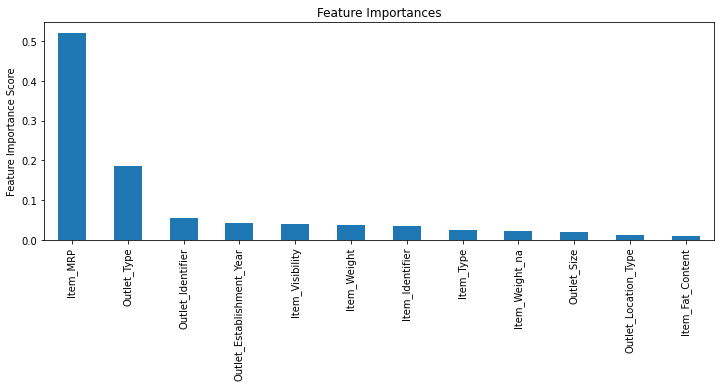

In [ ]:
modelfit(m_rf, train_x,train_y)

In [ ]:
result_reg(m_rf,valid_x,valid_y)

RMSE : 1128


In [ ]:
m_rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=200, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)>

## Vamos a mejorar el Random Forest. Primero estimators

1.- Primero vemos el número óptimo de estimators: con 80 ewstimator -> RMSE 1168

---



In [ ]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(max_samples=200,max_features=0.5, min_samples_leaf=5,random_state=10),param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch1.fit(train_x,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=0.5,
                                             max_leaf_nodes=None,
                                             max_samples=200,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=10,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=4,


In [ ]:
gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 80}, -1090.3176169641627)

In [ ]:
result_reg(gsearch1.best_estimator_,valid_x,valid_y)

RMSE : 1123


2.- Vamos a optimizar 'max_depth' y 'min_samples_split'

---


In [ ]:
param_test2 = {'max_depth':range(2,8,2), 'min_samples_split':range(2,12,1)}

In [ ]:
gsearch2= GridSearchCV(estimator=RandomForestRegressor(n_estimators=80,max_samples=200,max_features=0.5, min_samples_leaf=5,random_state=10),param_grid=param_test2,scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch2.fit(train_x,train_y)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=0.5,
                                             max_leaf_nodes=None,
                                             max_samples=200,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=80, n_jobs=None,
                                             oob_score=False, random_state=10,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=4,
 

In [ ]:
gsearch2.best_params_,gsearch2.best_score_

({'max_depth': 6, 'min_samples_split': 2}, -1094.144183681116)

In [ ]:
result_reg(gsearch2.best_estimator_,valid_x,valid_y)

RMSE : 1124


Resultado

In [ ]:
m_rf_opt=RandomForestRegressor(n_estimators=80,max_samples=200,max_features=0.5, min_samples_leaf=5,min_samples_split=11,random_state=10)

In [ ]:
m_rf_opt.fit(train_x, train_y);

In [ ]:
result_reg(m_rf_opt,valid_x,valid_y)

RMSE : 1120


In [ ]:
save_pickle(path/'model_rf.pkl',m_rf_opt)

In [ ]:
pred_rf=m_rf_opt.predict(test_x)

NameError: ignored

In [ ]:
df_test[]=

In [ ]:
df_test['Item_Outlet_Sales']=pred_rf

In [ ]:
result_rf=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_rf.to_csv(path/'submit_rff.csv',index=False)

## Vamos a optimizar GBoostModel

In [ ]:
#to= load_pickle(path/'to_opt_nor.pkl')
to = load_pickle(path/'to_mod.pkl')

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
#Choose all predictors except target & IDcols
#predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch1.fit(train_x,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=8,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
            

In [ ]:
gsearch1.cv_results_,gsearch1.best_params_,gsearch1.best_score_

({'mean_fit_time': array([0.20860648, 0.33953242, 0.43872862, 0.5398519 , 0.63806324,
         0.73974104, 0.74660254]),
  'mean_score_time': array([0.00944557, 0.00720091, 0.01028156, 0.01014094, 0.01012483,
         0.01112671, 0.00863609]),
  'mean_test_score': array([-1126.243458  , -1093.65951454, -1082.11571799, -1078.13763371,
         -1078.66270443, -1079.21720772, -1080.3969927 ]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'rank_test_score': array([7, 6, 5, 1, 2, 3, 4], dtype=int32),
  'split0_test_score': array([-1176.33229183, -1145.80837513, -1137.49872199, -1130.53656113,
         -1131.66613948, -1134.78972157, -1137.02928644]),
  'sp

Vamos a afinar


1.   x_depth y num_samples_splits
2.   min_samples_leaf
3. max_features




In [ ]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch2.fit(train_x,train_y)


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=60,
                                                 n_iter_no_change=None,
                

In [ ]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.57166305, 0.55703664, 0.52356219, 0.53426275, 0.49727497,
         0.70084162, 0.66415348, 0.61447043, 0.57900867, 0.54330397,
         0.79913325, 0.72044501, 0.65367298, 0.60408125, 0.56406431,
         0.87317858, 0.78761692, 0.69158001, 0.61766248, 0.58562465,
         0.90737062, 0.80779314, 0.68657541, 0.61688685, 0.60365343,
         0.92678723, 0.81240907, 0.71503191, 0.63330779, 0.49538302]),
  'mean_score_time': array([0.01458163, 0.00825095, 0.00848265, 0.00896096, 0.0094192 ,
         0.01365051, 0.0119453 , 0.00728183, 0.00921779, 0.00994358,
         0.01234541, 0.01188021, 0.0092063 , 0.01105576, 0.01064401,
         0.01172585, 0.01050434, 0.01114483, 0.01008472, 0.00776062,
         0.01625137, 0.00843725, 0.01411057, 0.00997791, 0.00805173,
         0.01366258, 0.01606669, 0.01141424, 0.00739775, 0.0056901 ]),
  'mean_test_score': array([-1077.73785321, -1078.15149311, -1077.33077487, -1078.85717286,
         -1079.6397077 , -1081.86973109,

Vamos a estudiar los parámetros min_samples_split y min_samples_leaf

In [ ]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=60,max_depth=5,max_features='sqrt',min_samples_split=600, subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='neg_root_mean_squared_error',n_jobs=4,cv=5)
gsearch3.fit(train_x,train_y)


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=5,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=600,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=60,
                                                 n_ite..._change=None,
               

In [ ]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.47581406, 0.47548556, 0.4463973 , 0.43245611, 0.43916793,
         0.38621421, 0.47116785, 0.45802379, 0.44490728, 0.42158146,
         0.41561399, 0.38925343, 0.47273388, 0.46049004, 0.44888153,
         0.4340517 , 0.39299145, 0.38367715, 0.47551093, 0.46445742,
         0.44245906, 0.41939096, 0.4431664 , 0.37986579, 0.47419109,
         0.47607603, 0.44806476, 0.44947457, 0.39131665, 0.3318089 ]),
  'mean_score_time': array([0.00659399, 0.00946774, 0.00879803, 0.00711923, 0.01103053,
         0.00744982, 0.0111526 , 0.00987763, 0.01081648, 0.00921898,
         0.00454273, 0.00874972, 0.00822296, 0.01003032, 0.00737085,
         0.00498881, 0.00509028, 0.01046247, 0.0068469 , 0.00408602,
         0.00819926, 0.00845938, 0.00502763, 0.00925641, 0.00827432,
         0.00801916, 0.00935316, 0.00722661, 0.00913606, 0.00589638]),
  'mean_test_score': array([-1078.00468717, -1083.96814686, -1087.77958825, -1095.25229269,
         -1092.44182857, -1096.35056532,

/nModel Report
RMSE : 1058
CV Score : Mean - -1078.005 | Std - 36.38877 | Min - -1132.318 | Max - -1024.434


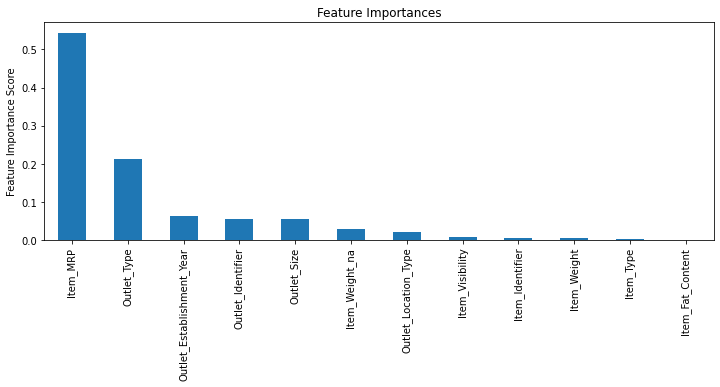

In [ ]:
modelfit(gsearch3.best_estimator_, train_x ,train_y)

In [ ]:
predictors = [x for x in train_x.columns if x not in [IDcol]]

NameError: ignored

In [ ]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='neg_root_mean_squared_error',n_jobs=4,cv=5)
gsearch4.fit(train_x,train_y)


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=9,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=60,
                                                 min_samples_split=1200,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=60,
                                                 n_iter_no_change=None,
              

In [ ]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.97735105, 1.29039402, 1.37475343, 0.00482845, 0.00536051,
         0.01117988, 0.00914745]),
  'mean_score_time': array([0.01088977, 0.0121347 , 0.00632071, 0.        , 0.        ,
         0.        , 0.        ]),
  'mean_test_score': array([-1079.59155131, -1075.97289   , -1075.27965305,            nan,
                    nan,            nan,            nan]),
  'param_max_features': masked_array(data=[7, 9, 11, 13, 15, 17, 19],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 7},
   {'max_features': 9},
   {'max_features': 11},
   {'max_features': 13},
   {'max_features': 15},
   {'max_features': 17},
   {'max_features': 19}],
  'rank_test_score': array([3, 2, 1, 4, 5, 6, 7], dtype=int32),
  'split0_test_score': array([-1132.6757142 , -1131.99652842, -1129.58195269,            nan,
                    nan,            nan,            nan]),
  'split1

In [ ]:
save_pickle(path/'model_xg_pkl',gsearch4.best_estimator_)

In [ ]:
model_gbm = load_pickle(path/'model_xg_pkl')

In [ ]:
pred_xg=model_gbm.predict(test_x)

In [ ]:
pred_xg=gsearch4.best_estimator_.predict(test_x)

In [ ]:
pred_xg

array([1750.7870877 , 1421.1382474 ,  603.72238091, ..., 1785.90634199,
       3658.06920417, 1229.49550917])

In [ ]:
df_test['Item_Outlet_Sales']=pred_xg

In [ ]:
result_xg=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_xg.to_csv(path/'submit_xg.csv',index=False)

# Usamos NeuralNetwork como modelo

In [ ]:
#to_nn=load_pickle(path/'to_full_nor.pkl')
#to_nn=load_pickle(path/'to_opt_nor.pkl')
to_nn = load_pickle(path/'to_mod.pkl')

In [ ]:
to_nn.items

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,...,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_na
7361,315,15.200,3,0.104365,...,2,2,3151.897217,1
1517,1486,12.850,2,0.053527,...,1,2,2388.890381,1
3603,986,12.150,2,0.036361,...,3,1,330.236786,1
2243,1133,7.365,2,0.042801,...,2,2,2037.348022,1
3907,706,13.500,3,0.017887,...,1,2,1438.128052,1
...,...,...,...,...,...,...,...,...,...
5803,1145,6.195,2,0.072279,...,3,3,1807.646973,1
7261,63,7.810,2,0.067837,...,2,2,5375.669434,1
7221,757,12.600,2,0.156304,...,1,1,255.667206,2
4149,483,5.590,3,0.056603,...,1,2,1725.753540,1


In [ ]:
to_nn.procs.add(Normalize())

In [ ]:
to.setup()

In [ ]:
to.items

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,...,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_na
7361,0,15.200,0,0.104365,...,0,0,3151.897217,1
1517,0,12.850,0,0.053527,...,0,0,2388.890381,1
3603,0,12.150,0,0.036361,...,0,0,330.236786,1
2243,0,7.365,0,0.042801,...,0,0,2037.348022,1
3907,0,13.500,0,0.017887,...,0,0,1438.128052,1
...,...,...,...,...,...,...,...,...,...
5803,0,6.195,0,0.072279,...,0,0,1807.646973,1
7261,0,7.810,0,0.067837,...,0,0,5375.669434,1
7221,0,12.600,0,0.156304,...,0,0,255.667206,1
4149,0,5.590,0,0.056603,...,0,0,1725.753540,1


In [ ]:
dls = to_nn.dataloaders(64,set_seed=52)

In [ ]:
to_nn.train.y.max(),to_nn.train.y.min(),

(13086.96484375, 33.290000915527344)

In [ ]:
learn = tabular_learner(dls,layers=[200,100],metrics=rmse,y_range=[-100,15000.],wd=0.9)

In [ ]:
#learn.summary()

SuggestedLRs(valley=tensor(0.0063))

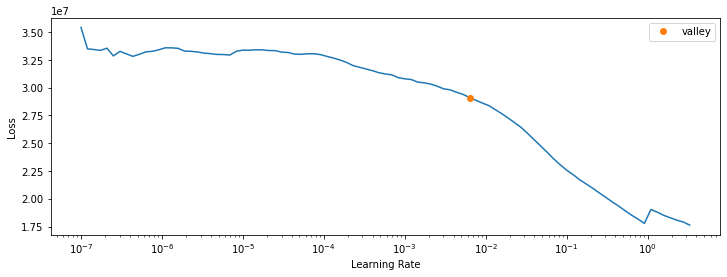

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5,9e-4)

epoch,train_loss,valid_loss,_rmse,time
0,828197.625000,1549979.250000,1244.981567,00:01
1,867461.500000,1476903.000000,1215.278931,00:01
2,804908.000000,1480990.375000,1216.959473,00:01
3,693819.062500,1628479.250000,1276.118774,00:01
4,617653.437500,1673061.875000,1293.468994,00:01


In [ ]:
learn.save('model_nn3')

Path('models/model_nn3.pth')

In [ ]:
learn.load('model_nn3')

In [ ]:
learn.fit_one_cycle(1,1e-1)

epoch,train_loss,valid_loss,_rmse,time
0,7763880.500000,7505047.500000,2739.534180,00:01


In [ ]:
dl=learn.dls.test_dl(df1_test)

In [ ]:
pred,_=learn.get_preds(dl=dl)

In [ ]:
pred.numpy()

array([[1809.5634 ],
       [1398.3076 ],
       [ 489.10516],
       ...,
       [1838.5967 ],
       [3862.3418 ],
       [1268.1895 ]], dtype=float32)

In [ ]:
df_test['Item_Outlet_Sales']=pred.numpy()

In [ ]:
result_nn=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_nn.to_csv(path/'submit_nn3.csv',index=False)

In [ ]:
result_nn.loc[result_nn['Item_Outlet_Sales'] < 100]

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
30,NCR42,OUT019,82.219589
1294,FDD08,OUT019,98.126816
2167,FDG22,OUT019,96.694077
2179,FDQ47,OUT019,93.934692
2522,FDX59,OUT010,93.882858
2609,NCE31,OUT019,96.571274
2798,FDU15,OUT019,84.260498
4409,FDG59,OUT019,89.082993
5016,FDG40,OUT019,98.270172


# Tratamiento de datos LUX

In [ ]:
path= PosixPath('/content/drive/MyDrive/data/bigmartsales')


In [ ]:
df1=pd.read_csv(path/'train.csv',delimiter=',')
df1_test=pd.read_csv(path/'test.csv',delimiter=',')

In [ ]:
# lo pasamos a string para que sea categorical
df1['Outlet_Establishment_Year']=df1['Outlet_Establishment_Year'].astype('string')
df1_test['Outlet_Establishment_Year']=df1_test['Outlet_Establishment_Year'].astype('string')

In [ ]:
df1.drop(['Item_Identifier'],axis=1,inplace=True)
df1_test.drop(['Item_Identifier'],axis=1,inplace=True)

In [ ]:
#df1["Item_Outlet_Sales"]=np.log(df1["Item_Outlet_Sales"])


In [ ]:
def mapear(val):
    if val == 0.0:
        return 'None'
    elif  (val > 0.0) & (val < 0.04):
        return 'low'
    elif  (val >= 0.04) & (val < 0.07):
        return 'med'
    elif (val >= 0.7) & (val < 0.13):
        return 'high'
    else:
        return 'veryHigh'

In [ ]:
df1['Item_Visibility_mod']=df1['Item_Visibility'].apply(lambda x: mapear(x))
df1_test['Item_Visibility_mod']=df1_test['Item_Visibility'].apply(lambda x: mapear(x))

In [ ]:
df1['Outlet_Size'].fillna('None',inplace=True)
df1_test['Outlet_Size'].fillna('None',inplace=True)

In [ ]:
dep_var='Item_Outlet_Sales'

In [ ]:
cont,cat = cont_cat_split(df1,max_card=200,dep_var=dep_var)

In [ ]:
splits = RandomSplitter()(range_of(df1))

In [ ]:
procs=[Categorify,FillMissing,Normalize]
to=TabularPandas(df1,procs=procs,cat_names=cat,cont_names=cont,y_names=dep_var,splits=splits)

In [ ]:
cat

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Visibility_mod',
 'Item_Weight_na']

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

In [ ]:
m_rf = rf(train_x, train_y);

In [ ]:
modelfit(m_rf, train_x,train_y)

NameError: ignored

In [ ]:
result_reg(m_rf,valid_x,valid_y)

RMSE : 1055


In [ ]:
save_pickle(path/'to_opt_nor1.pkl',to)

# Predicciones TEST

In [ ]:
to=load_pickle(path/'to_opt_nor.pkl')

In [ ]:
to_test=to.new(df1_test)

In [ ]:
to_test.process()

In [ ]:
to_test.xs.shape

(5681, 12)

In [ ]:
test_x=to_test.xs

In [ ]:
to_test.items

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,...,Outlet_Location_Type,Outlet_Type,Item_Visibility_mod,Item_Weight_na
0,1.883157,2,-1.138225,14,...,1,2,2,1
1,-1.069836,5,-0.537006,5,...,2,2,2,1
2,0.424450,2,0.654163,12,...,3,1,4,1
3,-1.303466,2,-0.985819,14,...,2,2,2,1
4,-0.049926,3,1.024764,5,...,3,4,4,2
...,...,...,...,...,...,...,...,...,...
5676,-0.548022,3,-1.022674,14,...,1,2,2,1
5677,-1.235868,3,1.499921,16,...,3,3,4,1
5678,-0.666616,2,0.146771,9,...,2,2,4,1
5679,0.590482,3,-1.285590,4,...,2,2,1,1


Modelo XGBoost

In [ ]:
pred_xgb=xgb2.predict(to_test.items)

ValueError: ignored

In [ ]:
modelo_rf=load_pickle(path/'model_rf.pkl')

In [ ]:
pred=modelo_rf.predict(to_test.items)

In [ ]:
df_test['Item_Outlet_Sales'] = pred

In [ ]:
df_test[df_test['Item_Identifier'] == 'DRC01']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,...,Outlet_Location_Type,Outlet_Type,resultado,Item_Outlet_Sales
930,DRC01,5.92,Regular,0.032137,...,Tier 3,Grocery Store,3577.842864,3577.842864
2065,DRC01,5.92,Regular,0.019196,...,Tier 2,Supermarket Type1,3598.749657,3598.749657
4264,DRC01,5.92,Regular,0.019230,...,Tier 1,Supermarket Type1,3291.093831,3291.093831


In [ ]:
modelo_rf.predict(valid_x)

array([1571.04695394, 2199.86853458, 1954.168808  , ..., 2487.11099297,
       3077.90311829, 3606.82100645])

In [ ]:
result_reg(modelo_rf,valid_x,valid_y)

RMSE : 1060


In [ ]:
result_rf=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_rf.to_csv(path/'submit_rf3.csv',index)

In [ ]:
resultado=pd.DataFrame()

In [ ]:
resultado['p_rf']=pred_rf

In [ ]:
resultado['p_xg']=pred_xg

In [ ]:
resultado['p_nn']=pred.numpy()

In [ ]:
resultado['med']=0.5*resultado['p_xg']+0.5*resultado['p_nn']

In [ ]:
resultado

,p_xg,p_nn,med
0,1750.787088,1809.563354,1780.175221
1,1421.138247,1398.307617,1409.722932
2,603.722381,489.105164,546.413772
3,2549.001673,2667.123291,2608.062482
4,5507.840958,6121.130371,5814.485665
...,...,...,...
5676,2162.695869,2312.010010,2237.352940
5677,2572.393993,2454.290527,2513.342260
5678,1785.906342,1838.596680,1812.251511
5679,3658.069204,3862.341797,3760.205501


In [ ]:
resultado['media3']=(0.2*resultado['p_rf']+0.45*resultado['p_xg']+0.35*resultado['p_nn'])

In [ ]:
resultado

,p_rf,p_xg,p_nn,media,media2,media3
0,1870.349917,1750.787088,1786.673706,1802.603570,1787.259988,1787.259988
1,1495.859976,1421.138247,1403.345581,1440.114601,1429.855166,1429.855166
2,973.169257,603.722381,484.338440,687.076693,635.827371,635.827371
3,2543.934398,2549.001673,2630.129883,2574.355318,2576.383103,2576.383103
4,5048.119260,5507.840958,6242.334961,5599.431727,5672.969422,5672.969422
...,...,...,...,...,...,...
5676,2266.556343,2162.695869,2247.779541,2225.677251,2213.247249,2213.247249
5677,2795.726380,2572.393993,2535.793213,2634.637862,2604.250161,2604.250161
5678,1839.092649,1785.906342,1839.874634,1821.624542,1815.432499,1815.432499
5679,3581.056296,3658.069204,3683.928711,3641.018070,3651.717401,3651.717401


In [ ]:
df_test['Item_Outlet_Sales'] = resultado['med']

In [ ]:
result_med=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_med.to_csv(path/'result_media6.csv',index=False)

#LightGBM

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
train_data = lgb.Dataset(train_x, train_y)

In [ ]:
valid_data = lgb.Dataset(valid_x, valid_y)

In [ ]:
param = {'num_leaves': 31}
param['metric'] = 'rsme'

In [ ]:
bst = lgb.train(param,train_data, valid_sets=[valid_data])

In [ ]:
ypred = bst.predict(test_x)

In [ ]:
ypred

array([1583.0509641 , 1268.58729933,  341.3213857 , ..., 1868.39544826,
       4564.20687088, 1206.20112711])

In [ ]:
result_reg(bst,valid_x,valid_y)

RMSE : 1077


In [ ]:
df_test['Item_Outlet_Sales'] = np.abs(ypred)

In [ ]:
result_lgb=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_lgb.to_csv(path/'result_lbm.csv',index=False)

In [ ]:
bst

#Resumen

## Preparamos los datos, limpiamos información y creamos TabulaPandas

In [ ]:
def features(df,test=False):
    # lo pasamos a string para que sea categorical
    df1 = df.copy()
    df1['Outlet_Establishment_Year']=df1['Outlet_Establishment_Year'].astype('string')

    df1.drop(['Item_Identifier'],axis=1,inplace=True)
    df1['Outlet_Size'].fillna('None',inplace=True)

    return df1

In [ ]:
path= PosixPath('/content/drive/MyDrive/data/bigmartsales')


In [ ]:
df=pd.read_csv(path/'train.csv',delimiter=',')
df_test=pd.read_csv(path/'test.csv',delimiter=',')

In [ ]:
df_train = features(df)

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


In [ ]:
df_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,...,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,...,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,...,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,...,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,...,None,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,...,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
dep_var='Item_Outlet_Sales'

In [ ]:
cont,cat = cont_cat_split(df_train,max_card=200,dep_var=dep_var)

In [ ]:
splits = RandomSplitter()(range_of(df_train))

In [ ]:
procs=[Categorify,FillMissing,Normalize]
to=TabularPandas(df_train,procs=procs,cat_names=cat,cont_names=cont,y_names=dep_var,splits=splits)

## Obtenemos los datos tratados para usarlos en los modelos.

Si utilizamos NN tenemos que obtener el dataloader

In [ ]:
train_x, train_y=to.train.xs,to.train.y
valid_x,valid_y=to.valid.xs,to.valid.y

Trabajamos con XGBoost que ofrece los mejores resultados

In [ ]:
def modelfit(alg, X,y, performCV=True, printFeatureImportance=True, cv_folds=5): 
    #Fit the algorithm on the data 
    alg.fit(X, y) 
    
    #Predict training set:
    dtrain_predictions = alg.predict(X) 
    #dtrain_predprob = alg.predict_proba(X)[:,1] 
    
    #Perform cross-validation: 
    if performCV:
        cv_score = cross_val_score(alg,X, y, cv=cv_folds, scoring='neg_root_mean_squared_error')
    #Print model report:
    print("/nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, dtrain_predictions)))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)) 
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" %(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))) 
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,list(X.columns)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
def result_reg(m,X,y):
    predictions = m.predict(X)
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, predictions)))
 
    

/nModel Report
RMSE : 1040
CV Score : Mean - -1095.477 | Std - 42.90819 | Min - -1151.237 | Max - -1028.795


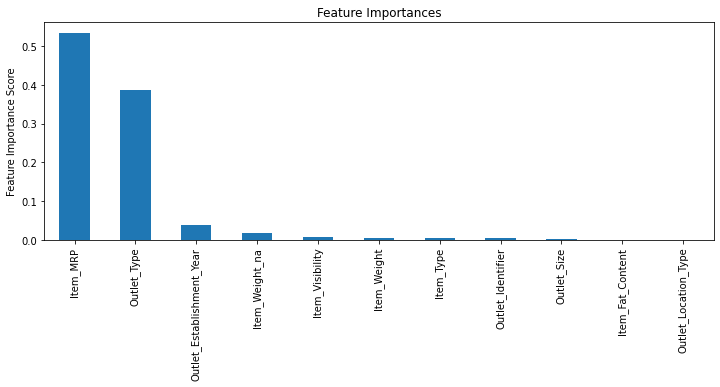

In [ ]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, train_x,train_y)

In [ ]:
result_reg(gbm0,valid_x,valid_y)  

RMSE : 1041


# XGBoost

In [ ]:
#to_xgb=load_pickle(path/'to_opt_nor.pkl')
to_xgb=load_pickle(path/'to_mod.pkl')

In [ ]:
train_x, train_y=to_xgb.train.xs,to_xgb.train.y
valid_x,valid_y=to_xgb.valid.xs,to_xgb.valid.y

In [ ]:
import xgboost as xgb 
from xgboost.sklearn import XGBClassifier,XGBRegressor 
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV #Perforing grid search 
import matplotlib.pylab as plt 

from matplotlib.pylab import rcParams 

rcParams['figure.figsize'] = 12, 4 



In [ ]:
def modelfit(alg, X,y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X,label=y) 
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='rmse', early_stopping_rounds=early_stopping_rounds,show_stdv=False) 
        alg.set_params(n_estimators=cvresult.shape[0]) 
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='rmse') 
    
    #Predict training set: 
    dtrain_predictions = alg.predict(X) 
     
    
    #Print model report: 
    print("\nModel Report") 
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, dtrain_predictions)))
    feat_imp = pd.Series(alg.get_booster().get_score()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances') 
    plt.ylabel('Feature Importance Score')



Model Report
RMSE : 1005


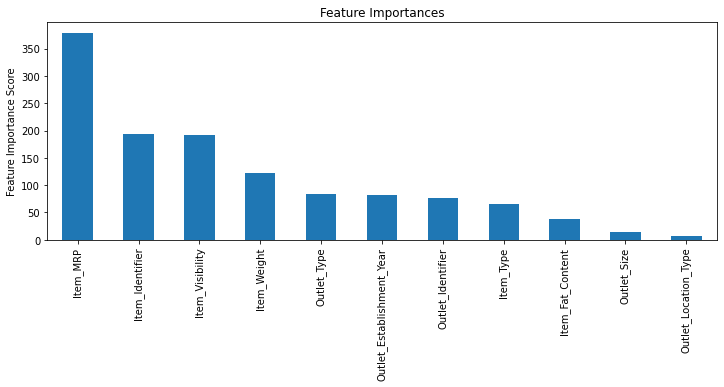

In [ ]:
#Choose all predictors except target & IDcols 

xgb1 = XGBRegressor( learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1,gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=27) 

modelfit(xgb1, train_x,train_y)

In [ ]:
pd.Series(xgb1.get_booster().get_score()).sort_values(ascending=False)

Item_MRP                     379
Item_Identifier              193
Item_Visibility              192
Item_Weight                  122
Outlet_Type                   84
Outlet_Establishment_Year     82
Outlet_Identifier             77
Item_Type                     65
Item_Fat_Content              38
Outlet_Size                   14
Outlet_Location_Type           7
dtype: int64

In [ ]:
def result_reg(m,X,y):
    predictions = m.predict(X)
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y, predictions)))

In [ ]:
result_reg(xgb1,train_x,train_y)

RMSE : 1005


In [ ]:
result_reg(xgb1,valid_x,valid_y)

RMSE : 1113


In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* **max_depth = 5**: This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* **min_child_weight = 1**: A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* **gamma = 0**: A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* **subsample, colsample_bytree = 0.8** : This is a commonly used used start value. Typical values range between 0.5-0.9.
* **scale_pos_weight = 1**: Because of high class imbalance.

In [ ]:
xgb1 = XGBRegressor(
 learning_rate =0.05,
 n_estimators=3500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)




Model Report
RMSE : 1006


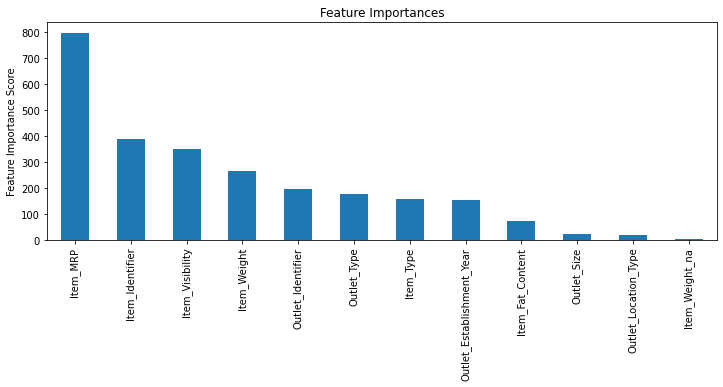

In [ ]:
modelfit(xgb1, train_x, train_y)

In [ ]:
result_reg(xgb1,valid_x,valid_y)

RMSE : 1114


**Step 2: Tune max_depth and min_child_weight**

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(target,pred):
    return np.sqrt(mean_squared_error(target, pred)) 

In [ ]:
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,n_jobs=4,cv=5)

gsearch1.fit(train_x,train_y)


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=140, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             

In [ ]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.82701216, 1.26670051, 1.24321775, 2.06053429, 2.05221672,
         2.07207727, 3.10264239, 2.93379045, 2.85176387, 4.113941  ,
         3.98717184, 3.29014497]),
  'mean_score_time': array([0.01711192, 0.01608462, 0.01863694, 0.03568873, 0.02481432,
         0.0351315 , 0.03306103, 0.03867083, 0.03963614, 0.04556513,
         0.05366435, 0.02813711]),
  'mean_test_score': array([0.59410093, 0.59423987, 0.59338089, 0.57385371, 0.57563164,
         0.57565503, 0.55353664, 0.55020916, 0.55055774, 0.52594851,
         0.52845966, 0.52648121]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, False,
       

In [ ]:
result_reg(gsearch1.best_estimator_,valid_x,valid_y),result_reg(gsearch1.best_estimator_,train_x,train_y)

RMSE : 1113
RMSE : 1006


(None, None)

Vamos a intentar afinar con unvalor por encima y uno poor debajo

In [ ]:
param_test2 = {
 'max_depth':[1,2,3,4],
 'min_child_weight':[1,2,3,4]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2,n_jobs=4,cv=5)

gsearch2.fit(train_x,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=140, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_child_weight': [1, 2, 3, 4]},
             pre_d

In [ ]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([1.05559835, 0.68298306, 0.67910609, 0.64703317, 0.99165225,
         0.96760077, 1.0117806 , 0.92319345, 1.35764141, 1.27818065,
         1.34671516, 1.33106718, 1.76425834, 1.71731033, 1.75729876,
         1.55455027]),
  'mean_score_time': array([0.00928154, 0.01540318, 0.01861067, 0.01541796, 0.01617694,
         0.02125063, 0.01606145, 0.01621728, 0.02247119, 0.02077599,
         0.02546868, 0.02843251, 0.02003064, 0.02541351, 0.02360244,
         0.02167044]),
  'mean_test_score': array([0.55089372, 0.55089372, 0.55089372, 0.55089372, 0.58782526,
         0.58807825, 0.58804387, 0.58789937, 0.58389413, 0.58366964,
         0.58416628, 0.58327483, 0.57459628, 0.57591387, 0.57610106,
         0.57699606]),
  'param_max_depth': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False],
         fi

In [ ]:
result_reg(gsearch2.best_estimator_,valid_x,valid_y),result_reg(gsearch2.best_estimator_,train_x,train_y)

RMSE : 1040
RMSE : 1061


(None, None)

Probamos con lo que tenemos hasta ahora


Model Report
RMSE : 1034


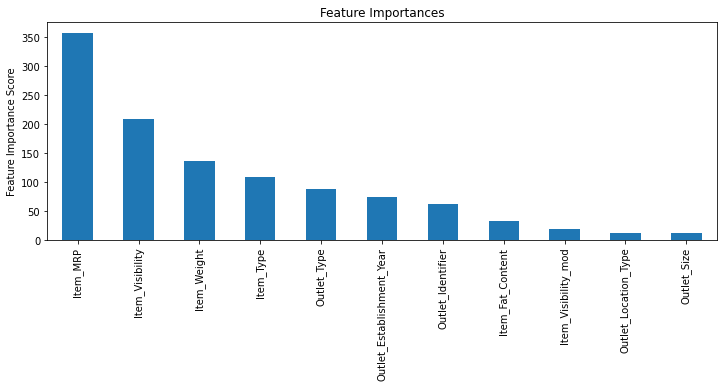

In [ ]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=6,
 gamma=0.9,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, train_x, train_y)

In [ ]:
result_reg(xgb2,valid_x,valid_y),result_reg(xgb2,train_x,train_y)

RMSE : 1042
RMSE : 1034


(None, None)

**Step 3: Tune gamma**

Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,4)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2, min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  


In [ ]:
gsearch3.fit(train_x,train_y)


KeyboardInterrupt: ignored

In [ ]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
result_reg(gsearch3.,valid_x,valid_y),result_reg(gsearch3.,train_x,train_y)

**Step 4: Tune subsample and colsample_bytree**

The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=3,
                                                 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 objective= 'neg_root_mean_squared_error', nthread=4, scale_pos_weight=1,seed=27),param_grid = param_test4, scoring='neg_root_mean_squared_error',n_jobs=4,iid=False, cv=5)

In [ ]:
gsearch4.fit(train_x,train_y)

In [ ]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
result_reg(gsearch4.,valid_x,valid_y),result_reg(gsearch4.,train_x,train_y)

**Step 5: Tuning Regularization Parameters**


Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

calculamos lapredicción 

In [ ]:
to_test=to_xgb.new(df1_test)

In [ ]:
to_test.process()

In [ ]:
test_x=to_test.xs

In [ ]:
train_x.shape, test_x.shape

((6819, 12), (5681, 12))

In [ ]:
xgtest = xgb.DMatrix(test_x) 

In [ ]:
pred_xgb=xgb2.predict(test_x)

In [ ]:
df_test['Item_Outlet_Sales'] = np.abs(pred_xgb)

In [ ]:
result_rf=df_test.loc[:,['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [ ]:
result_rf.to_csv(path/'submit_xgb2.csv',index=False)